# PyTorch implementation

This script is training a Convolutional Neural Network (CNN) to perform an image classification task. The model is built using PyTorch and is trained on a custom dataset of images. Here's a simple explanation of each part:

1. Import Libraries: Importing necessary libraries and modules for data manipulation, model creation, and training.

2. Parameters: Setting various parameters such as path of data, number of epochs for training, batch size, dimensions of images, test and validation ratios etc.

3. Load and split data: The load_data() function loads the images from the given path and assigns them their respective class labels. It splits the data into training, validation, and testing datasets using sklearn's train_test_split().

4. Create PyTorch Dataset: The MyDataset class creates a custom PyTorch dataset. It overrides the __getitem__() and __len__() methods for indexing and returning the length of the dataset, respectively. If any transformations are provided, they are applied to the images.

5. Data Augmentation: Defines transformations for data augmentation, which are applied to the images in the dataset for better model generalization. The transformations include converting to PIL image, applying random horizontal flips and rotations, and then converting to a tensor.

6. CNN Model: Defines a CNN architecture (Net class) with two convolutional layers followed by max pooling, and two fully connected layers for the classification. The forward() method defines the forward pass for the model.

7. Training Function: The train_model() function performs the model training. It takes the model, loss function, optimizer, data loaders, and number of epochs as arguments. It also evaluates the model's performance on the validation dataset after each epoch and prints the loss and accuracy.

8. Load the Data: The data is loaded and split into training, validation, and test sets by calling the load_data() function.

9. Create DataLoaders: PyTorch DataLoader objects are created for the training, validation, and test datasets. These are used to feed data into the model in batches during training and evaluation.

10. Create the Model: An instance of the defined CNN model (Net) is created.

11. Loss Function and Optimizer: CrossEntropyLoss is used as the loss function, which is suitable for multi-class classification tasks. The Adam optimizer is used to update the model parameters.

12. Train the Model: The model is trained using the defined training function (train_model()).

13. Save the Model: The trained model parameters are saved to a file ("trained_model.pt") for later use or deployment.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import cv2
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

###################################################################

# Parameters
path = "C:/Users/elvis/OneDrive - uniroma1.it/TRAFFIC SIGNS RECOGNITION/dataset"
labelFile = "C:/Users/elvis/OneDrive - uniroma1.it/TRAFFIC SIGNS RECOGNITION/Traffic-signs-recognition-PyTorch/labels.csv"
batch_size_val = 50
steps_per_epoch_val = 2000
epochs_val = 30
imageDimesions = (32,32,3)
testRatio = 0.2
validationRatio = 0.2

# Load and split the data
def load_data():
    images = []
    classNo = []
    myList = os.listdir(path)
    print("Total Classes Detected:", len(myList))
    noOfClasses = len(myList)
    print("Importing Classes.....")
    for x in range(len(myList)):
        myPicList = os.listdir(path + "/" + str(x))
        for y in myPicList:
            curImg = cv2.imread(path + "/" + str(x) + "/" + y)
            images.append(curImg)
            classNo.append(x)
        print(x, end=" ")
    print(" ")

    images = np.array(images)
    classNo = np.array(classNo)

    X_train, X_test, y_train, y_test = train_test_split(images, classNo, test_size=testRatio)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validationRatio)

    return X_train, X_validation, X_test, y_train, y_validation, y_test, noOfClasses

# Create PyTorch Dataset
class MyDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = torch.LongTensor(targets)
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]

        if self.transform:
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

# Data Augmentation
data_transform = transforms.Compose([
    transforms.ToPILImage(), # convert numpy array to PILImage
    transforms.RandomHorizontalFlip(),  # randomly flip images (data augmentation) during training time only
    transforms.RandomRotation(10), # randomly rotate images (data augmentation) during training time only
    transforms.ToTensor(), # convert numpy array to tensor
])

# We are random flipping and rotating the images to make our model more robust to different variations of the same image (data augmentation)

# CNN Model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 60, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(60, 30, 5)
        self.fc1 = nn.Linear(30 * 5 * 5, 500)
        self.fc2 = nn.Linear(500, noOfClasses)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 30 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Training function
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs):
    for epoch in range(epochs):
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in val_loader:
                images, labels = data
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        print('Epoch: {}, Loss: {:.5f}, Accuracy: {:.5f}%'.format(epoch+1, val_loss/total, (correct/total)*100))

    return model

# Load the data
X_train, X_validation, X_test, y_train, y_validation, y_test, noOfClasses = load_data()

# Create DataLoaders
train_data = MyDataset(X_train, y_train, data_transform)
val_data = MyDataset(X_validation, y_validation, data_transform)
test_data = MyDataset(X_test, y_test, data_transform)

train_loader = DataLoader(train_data, batch_size=batch_size_val, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size_val, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size_val, shuffle=False)

# Create the model
model = Net()

# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
model = train_model(model, criterion, optimizer, train_loader, val_loader, epochs=epochs_val) # 30 epochs

# Save the model
torch.save(model.state_dict(), "trained_model.pt")

# Live recognition

This script is capturing a live video feed from a webcam and using the pretrained Convolutional Neural Network (CNN) model to classify objects in the video feed (traffic signs). Here's a simple explanation of each part:

1. Import Libraries: Necessary libraries are imported.

2. Configuration Parameters: Sets various parameters such as frame dimensions, brightness, and classification threshold. The font for OpenCV's text output is also set.

3. Video Capture Initialization: Initializes a video capture object cap using OpenCV's cv2.VideoCapture(0). This opens the webcam for video capture. Frame width, height, and brightness are set for the video capture object.

4. CNN Model: Defines a CNN architecture. The model has two convolutional layers, followed by max pooling, and two fully connected layers.

5. Model Loading: Loads the pretrained weights from 'trained_model.pt' into the model and sets it to evaluation mode.

6. Transforms: Specifies transformations applied to each frame captured from the video feed before feeding it to the model for inference.

7. Class Names Function: The getClassName function maps the class indices to the actual names of the traffic signs.

8. Main Loop: The script enters a main loop where it continuously reads frames from the video capture object and processes them:

    - First, the frame is converted from BGR to RGB.
    - Then, the frame is transformed (resized, converted to tensor, and normalized) and an additional dimension is added to the tensor.
    - The transformed frame is fed into the model to get predictions.
    - If the prediction probability is higher than the threshold, the script puts the class index, class name, and prediction probability as text on the original image using OpenCV's cv2.putText.
    - The original image and processed image are displayed in two separate OpenCV windows.
    - The loop is broken when the 'q' key is pressed.
    
9. Clean Up: After the main loop is exited, the video capture is released and all OpenCV windows are destroyed.


## ATTEMPT 1

In [ ]:
import numpy as np
import cv2
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision.transforms as transforms

###################################################################

frameWidth = 640
frameHeight = 480
brightness = 180
threshold = 0.40
font = cv2.FONT_HERSHEY_SIMPLEX

cap = cv2.VideoCapture(0)
cap.set(3, frameWidth)
cap.set(4, frameHeight)
cap.set(25, brightness)

class Net(nn.Module):
    def __init__(self, no_of_classes):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 60, 5) 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(60, 30, 5)
        self.fc1 = nn.Linear(30 * 5 * 5, 500)
        self.fc2 = nn.Linear(500, no_of_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 30 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = Net(43)
model.load_state_dict(torch.load("trained_model.pt"))
model.eval()

# Define the transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Add normalization here.
])

def getClassName(classNo):
    if   classNo == 0: return 'Speed Limit 20 km/h'
    elif classNo == 1: return 'Speed Limit 30 km/h'
    elif classNo == 2: return 'Speed Limit 50 km/h'
    elif classNo == 3: return 'Speed Limit 60 km/h'
    elif classNo == 4: return 'Speed Limit 70 km/h'
    elif classNo == 5: return 'Speed Limit 80 km/h'
    elif classNo == 6: return 'End of Speed Limit 80 km/h'
    elif classNo == 7: return 'Speed Limit 100 km/h'
    elif classNo == 8: return 'Speed Limit 120 km/h'
    elif classNo == 9: return 'No passing'
    elif classNo == 10: return 'No passing for vechiles over 3.5 metric tons'
    elif classNo == 11: return 'Right-of-way at the next intersection'
    elif classNo == 12: return 'Priority road'
    elif classNo == 13: return 'Yield'
    elif classNo == 14: return 'Stop'
    elif classNo == 15: return 'No vechiles'
    elif classNo == 16: return 'Vechiles over 3.5 metric tons prohibited'
    elif classNo == 17: return 'No entry'
    elif classNo == 18: return 'General caution'
    elif classNo == 19: return 'Dangerous curve to the left'
    elif classNo == 20: return 'Dangerous curve to the right'
    elif classNo == 21: return 'Double curve'
    elif classNo == 22: return 'Bumpy road'
    elif classNo == 23: return 'Slippery road'
    elif classNo == 24: return 'Road narrows on the right'
    elif classNo == 25: return 'Road work'
    elif classNo == 26: return 'Traffic signals'
    elif classNo == 27: return 'Pedestrians'
    elif classNo == 28: return 'Children crossing'
    elif classNo == 29: return 'Bicycles crossing'
    elif classNo == 30: return 'Beware of ice/snow'
    elif classNo == 31: return 'Wild animals crossing'
    elif classNo == 32: return 'End of all speed and passing limits'
    elif classNo == 33: return 'Turn right ahead'
    elif classNo == 34: return 'Turn left ahead'
    elif classNo == 35: return 'Ahead only'
    elif classNo == 36: return 'Go straight or right'
    elif classNo == 37: return 'Go straight or left'
    elif classNo == 38: return 'Keep right'
    elif classNo == 39: return 'Keep left'
    elif classNo == 40: return 'Roundabout mandatory'
    elif classNo == 41: return 'End of no passing'
    elif classNo == 42: return 'End of no passing by vechiles over 3.5 metric tons'

while True:
    success, imgOrignal = cap.read()
    
    # Convert from BGR to RGB.
    # imgOrignal = cv2.cvtColor(imgOrignal, cv2.COLOR_BGR2RGB)
    
    img = transform(imgOrignal).unsqueeze(0)

    with torch.no_grad():
        predictions = model(img)
        probabilityValue, classIndex = F.softmax(predictions, dim=1).max(1)
        probabilityValue = probabilityValue.item()
        classIndex = classIndex.item()

    if probabilityValue > threshold:
        cv2.putText(imgOrignal,str(classIndex)+" "+str(getClassName(classIndex)), (120, 35), font, 0.75, (0, 0, 255), 2, cv2.LINE_AA)
        cv2.putText(imgOrignal, str(round(probabilityValue*100,2) )+"%", (180, 75), font, 0.75, (0, 0, 255), 2, cv2.LINE_AA)
    else:
        cv2.putText(imgOrignal,"No Signal Detected", (120, 35), font, 0.75, (0, 0, 255), 2, cv2.LINE_AA)

    cv2.namedWindow("Result", cv2.WINDOW_NORMAL)
    cv2.imshow("Result", imgOrignal)  # Convert back to BGR for display.
    cv2.imshow("Processed Image", np.transpose((img.squeeze(0).numpy() * 0.5) + 0.5, (1, 2, 0)))  # Undo normalization for display.

    k = cv2.waitKey(1)
    if k == ord('q'): # wait for 'q' key to exit
        break

cap.release()
cv2.destroyAllWindows()

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output


In [1]:
import numpy as np
import cv2
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision.transforms as transforms
from IPython.display import clear_output
import matplotlib.pyplot as plt

# Kích thước ảnh
frameWidth, frameHeight = 640, 480
threshold = 0.40

# Load model
class Net(nn.Module):
    def __init__(self, no_of_classes):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 60, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(60, 30, 5)
        self.fc1 = nn.Linear(30 * 5 * 5, 500)
        self.fc2 = nn.Linear(500, no_of_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 30 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = Net(43)
model.load_state_dict(torch.load("trained_model.pt", map_location=torch.device('cpu')))
model.eval()

# Danh sách nhãn
def getClassName(classNo):
    classes = [
        "Speed Limit 20", "Speed Limit 30", "Speed Limit 50", "Speed Limit 60",
        "Speed Limit 70", "Speed Limit 80", "End Limit 80", "Speed Limit 100",
        "Speed Limit 120", "No passing", "No passing > 3.5t", "Right-of-way",
        "Priority road", "Yield", "Stop", "No vehicles", "No > 3.5t", "No entry",
        "Caution", "Curve left", "Curve right", "Double curve", "Bumpy road",
        "Slippery road", "Narrow road", "Road work", "Traffic signals", "Pedestrians",
        "Children", "Bicycles", "Ice/snow", "Animals", "End all limits", "Turn right",
        "Turn left", "Ahead only", "Go straight or right", "Go straight or left",
        "Keep right", "Keep left", "Roundabout", "End no passing", "End no pass >3.5t"
    ]
    return classes[classNo] if 0 <= classNo < len(classes) else "Unknown"

# Tiền xử lý ảnh
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Pipeline GStreamer cho CSI camera
gst_pipeline = (
    "nvarguscamerasrc ! video/x-raw(memory:NVMM), width=640, height=480, "
    "format=NV12, framerate=30/1 ! nvvidconv flip-method=0 ! "
    "video/x-raw, format=BGRx ! videoconvert ! "
    "video/x-raw, format=BGR ! appsink"
)

cap = cv2.VideoCapture(gst_pipeline, cv2.CAP_GSTREAMER)
if not cap.isOpened():
    print("❌ Không mở được camera.")
else:
    print("✅ Camera CSI đã sẵn sàng.")


✅ Camera CSI đã sẵn sàng.


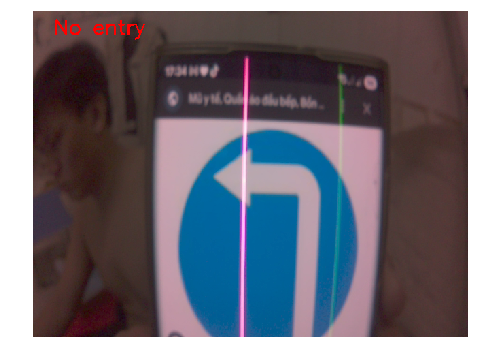

In [2]:
# Đọc và xử lý 1 khung hình
ret, imgOriginal = cap.read()
if not ret:
    print("❌ Không lấy được ảnh.")
else:
    img = transform(imgOriginal).unsqueeze(0)

    with torch.no_grad():
        output = model(img)
        prob, classIdx = F.softmax(output, dim=1).max(1)
        prob = prob.item()
        classIdx = classIdx.item()

    label = getClassName(classIdx) if prob > threshold else "No Sign"
    print(f"📍 Dự đoán: {label} ({round(prob * 100, 2)}%)")

    # Hiển thị hình ảnh
    imgShow = cv2.putText(imgOriginal.copy(), label, (30, 35),
                          cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    
    clear_output(wait=True)
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(imgShow, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


In [ ]:
cap.release()
cv2.destroyAllWindows()
